In [29]:
#Load Image and Annotations Function:
#Loads an image and its corresponding annotations from the JSON file.


In [30]:
#Image Preprocessing Function:
#Resize and normalize images.

In [90]:
import numpy as np
def preprocess_single_image(image_path, img_width=224, img_height=224):
    try:
        with Image.open(image_path) as img:
            img = img.resize((img_width, img_height), Image.ANTIALIAS)
            img = np.array(img, dtype=np.float32) / 255.0  # Normalize image data to 0-1
            return img
    except IOError:
        print(f"Failed to load or process image at {image_path}")
        return None


In [94]:
from PIL import Image
import numpy as np
import json
import os

def load_and_preprocess_data(img_folder, json_folder, img_width=224, img_height=224):
    images = []
    labels = []

    for img_file in sorted(os.listdir(img_folder)):
        img_number = img_file.split('_')[1].split('.')[0]
        img_path = os.path.join(img_folder, img_file)
        label_path = os.path.join(json_folder, f"label_{img_number}.json")

        try:
            with Image.open(img_path) as img:
                img = img.resize((img_width, img_height), Image.ANTIALIAS)
                img = np.array(img, dtype=np.float32) / 255.0
                images.append(img)
        except IOError:
            print(f"Failed to load or process image at {img_path}")
            continue

        if not os.path.exists(label_path):
            print(f"Label file not found at {label_path}")
            continue

        with open(label_path, 'r') as file:
            data = json.load(file)
            box_data = []
            for item in data['boxes']:
                if item['label'] == 'ball':
                    x_min = float(item['x']) / data['width']
                    y_min = float(item['y']) / data['height']
                    x_max = (float(item['x']) + float(item['width'])) / data['width']
                    y_max = (float(item['y']) + float(item['height'])) / data['height']
                    box_data.append([x_min, y_min, x_max, y_max])
            labels.append(box_data)

    return np.array(images), labels


In [95]:
from PIL import Image, ImageDraw
import numpy as np

def display_image_with_boxes_pil(image, boxes, expand_by=4):
    """
    Displays an image with bounding boxes drawn on it using PIL, with each box slightly larger.
    Also converts the image to grayscale.

    Parameters:
    - image: The image array (numpy array).
    - boxes: A list of bounding boxes, each represented as [center_x, center_y, width, height].
    - expand_by: Number of pixels to increase the size of each box by (total, not per side).
    """
    # Ensure the image is in uint8 format
    if image.dtype != np.uint8:
        image = (255 * image).astype(np.uint8)

    # Convert numpy array image to PIL Image
    pil_img = Image.fromarray(image)
    pil_img = pil_img.convert('L')  # Convert to grayscale

    # Create a drawing context
    draw = ImageDraw.Draw(pil_img)

    # Draw each box
    for box in boxes:
        center_x, center_y, width, height = map(int, box)
        top_left = (center_x - (width // 2) - (expand_by // 2), center_y - (height // 2) - (expand_by // 2))
        bottom_right = (center_x + (width // 2) + (expand_by // 2), center_y + (height // 2) + (expand_by // 2))
        draw.rectangle([top_left, bottom_right], outline="white", width=2)  # White box on grayscale image

    # Display the image
    pil_img.show()

# Example usage (assuming images and labels are already loaded and preprocessed)
if len(images) > 0 and len(labels) > 0:
    display_image_with_boxes_pil(images[0], labels[0])

In [33]:
#Data Augmentation Functions (optional):
#Rotate, flip, or crop images to create more diverse training data.
# NOT IMPLEMENTED

In [34]:
#Convolution Function:
#Applies a convolution operation to an image.

In [104]:
'''V1
import numpy as np

def convolve2d(image, kernel, stride=1, padding=1):
    """
    Apply a 2D convolution operation to an image, handling both grayscale and color images.
    
    Args:
    image (np.array): The input image array. Can be 2D (grayscale) or 3D (color).
    kernel (np.array): The kernel (filter) to apply.
    stride (int): The stride of the convolution.
    padding (int): The amount of padding around the image.
    
    Returns:
    np.array: The convolved image.
    """
    if image.ndim == 2:
        image = image[:, :, np.newaxis]  # Add a channel dimension to grayscale images
    
    kernel_height, kernel_width = kernel.shape
    image_height, image_width, num_channels = image.shape

    # Add padding to the image
    padded_height = image_height + 2 * padding
    padded_width = image_width + 2 * padding
    padded_image = np.zeros((padded_height, padded_width, num_channels))
    padded_image[padding:padding + image_height, padding:padding + image_width, :] = image

    # Determine the output dimensions
    out_height = ((padded_height - kernel_height) // stride) + 1
    out_width = ((padded_width - kernel_width) // stride) + 1
    output = np.zeros((out_height, out_width, num_channels))

    # Perform the convolution operation
    for z in range(num_channels):  # Iterate over each channel
        for y in range(out_height):
            for x in range(out_width):
                output[y, x, z] = np.sum(
                    kernel * padded_image[
                        y * stride: y * stride + kernel_height,
                        x * stride: x * stride + kernel_width,
                        z
                    ]
                )
    
    if output.shape[2] == 1:  # If it's a grayscale image, remove the channel dimension
        output = output[:, :, 0]
        
    return output
'''
def convolve2d(image, kernel, stride=1, padding=1):
    """
    Apply a 2D convolution operation to an image, handling both grayscale and color images.
    
    Args:
    image (np.array): The input image array. Can be 2D (grayscale) or 3D (color).
    kernel (np.array): The kernel (filter) to apply. Should have the shape (kernel_height, kernel_width, num_channels).
    stride (int): The stride of the convolution.
    padding (int): The amount of padding around the image.
    
    Returns:
    np.array: The convolved image.
    """
    if image.ndim == 2:
        image = image[:, :, np.newaxis]  # Add a channel dimension to grayscale images

    kernel_height, kernel_width, num_channels = kernel.shape
    image_height, image_width, image_channels = image.shape

    if num_channels != image_channels:
        raise ValueError("The number of channels in the kernel and the image must match.")

    # Add padding to the image
    padded_image = np.pad(image, ((padding, padding), (padding, padding), (0, 0)), mode='constant')

    # Determine the output dimensions
    out_height = (image_height + 2 * padding - kernel_height) // stride + 1
    out_width = (image_width + 2 * padding - kernel_width) // stride + 1
    output = np.zeros((out_height, out_width, num_channels))

    # Perform the convolution operation
    for z in range(num_channels):  # Iterate over each channel
        for y in range(out_height):
            for x in range(out_width):
                output[y, x, z] = np.sum(
                    kernel[:, :, z] * padded_image[
                        y * stride: y * stride + kernel_height,
                        x * stride: x * stride + kernel_width,
                        z
                    ]
                )

    return output





In [36]:
# Example usage
from PIL import Image

# Load an image and convert to a numpy array
img = Image.open('../images/image_1.png')
img_np = np.array(img)

# Define a simple edge-detection kernel
kernel = np.array([[1, 0, -1],
                   [1, 0, -1],
                   [1, 0, -1]])

# Apply the convolution operation
convolved_image = convolve2d(img_np, kernel, stride=1, padding=1)


In [37]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_images(original_img, convolved_img):
    """
    Visualize the original and convolved images side by side.

    Args:
    original_img (np.array): The original image.
    convolved_img (np.array): The image after convolution.
    """
    # Normalize the convolved image for better visualization
    convolved_img_normalized = (convolved_img - convolved_img.min()) / (convolved_img.max() - convolved_img.min())

    # Plot the original and the convolved images
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(original_img, cmap='gray')
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(convolved_img_normalized, cmap='gray')
    axes[1].set_title('Convolved Image')
    axes[1].axis('off')

    plt.show()


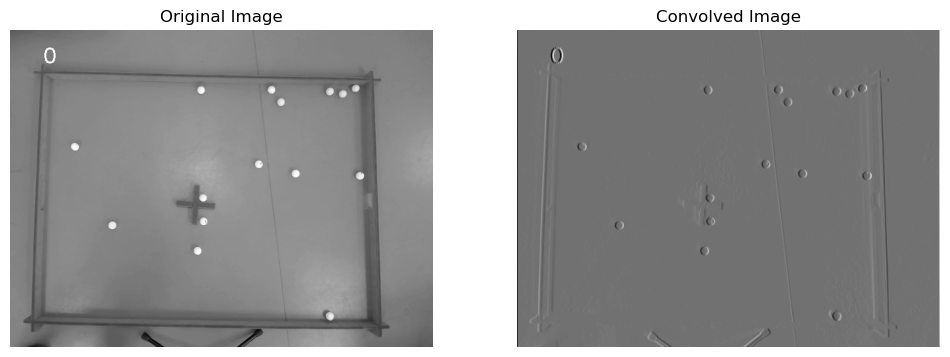

In [38]:
from PIL import Image
import numpy as np

# Load an image and convert to a numpy array
img_path = '../images/image_1.png'  # Change this to the path of your image
img = Image.open(img_path).convert('L')  # Convert to grayscale for simplicity
img_np = np.array(img)

# Define a simple edge-detection kernel
kernel = np.array([[1, 0, -1],
                   [1, 0, -1],
                   [1, 0, -1]])

# Apply the convolution operation
convolved_image = convolve2d(img_np, kernel, stride=1, padding=1)

# Visualize the original and the convolved images
visualize_images(img_np, convolved_image)


In [39]:
#ReLU Activation Function:
#Implements the ReLU activation to introduce non-linearity.

In [40]:
import numpy as np

def relu(x):
    """
    Apply the ReLU activation function to a numpy array or a single numeric value.
    
    Args:
    x (np.array or float): Input data (can be a single number, a vector, or a matrix).
    
    Returns:
    np.array or float: Output after applying the ReLU activation function.
    """
    return np.maximum(0, x)


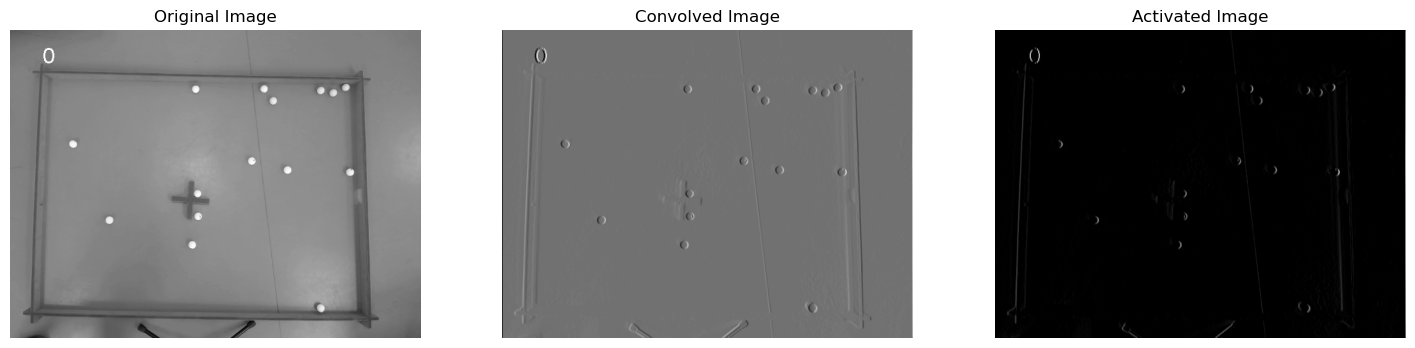

In [41]:
from PIL import Image
import matplotlib.pyplot as plt

# Load an image and convert it to grayscale
img = Image.open('../images/image_1.png').convert('L')
img_np = np.array(img)

# Define a simple edge-detection kernel
kernel = np.array([[1, 0, -1],
                   [1, 0, -1],
                   [1, 0, -1]])

# Apply the convolution operation
convolved_image = convolve2d(img_np, kernel, stride=1, padding=1)

# Apply the ReLU activation function
activated_image = relu(convolved_image)

# Visualize the results
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(convolved_image, cmap='gray')
plt.title('Convolved Image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(activated_image, cmap='gray')
plt.title('Activated Image')
plt.axis('off')

plt.show()



In [ ]:
#Pooling Function (optional but recommended):
#Applies a max pooling operation to reduce spatial dimensions.

In [43]:
import numpy as np

def max_pooling(image, pool_size=2, stride=2):
    """
    Apply max pooling operation to reduce the spatial dimensions of an image.
    
    Args:
    image (np.array): The input image array. Can be 2D (grayscale) or 3D (color).
    pool_size (int): The size of the pooling window, typically 2.
    stride (int): The stride with which the pooling window is slid across the image.
    
    Returns:
    np.array: The image after max pooling operation.
    """
    # Check if image is grayscale or color and get dimensions accordingly
    if image.ndim == 3:
        image_height, image_width, num_channels = image.shape
    else:
        image_height, image_width = image.shape
        num_channels = 1
        image = image[:, :, np.newaxis]  # Temporarily add channel dimension for consistency
    
    # Calculate the dimensions of the output
    out_height = (image_height - pool_size) // stride + 1
    out_width = (image_width - pool_size) // stride + 1
    pooled_image = np.zeros((out_height, out_width, num_channels))
    
    # Perform max pooling
    for z in range(num_channels):
        for y in range(out_height):
            for x in range(out_width):
                y_start = y * stride
                y_end = y_start + pool_size
                x_start = x * stride
                x_end = x_start + pool_size
                pooled_image[y, x, z] = np.max(image[y_start:y_end, x_start:x_end, z])

    # Remove temporary channel dimension for grayscale images
    if num_channels == 1:
        pooled_image = pooled_image[:, :, 0]
        
    return pooled_image



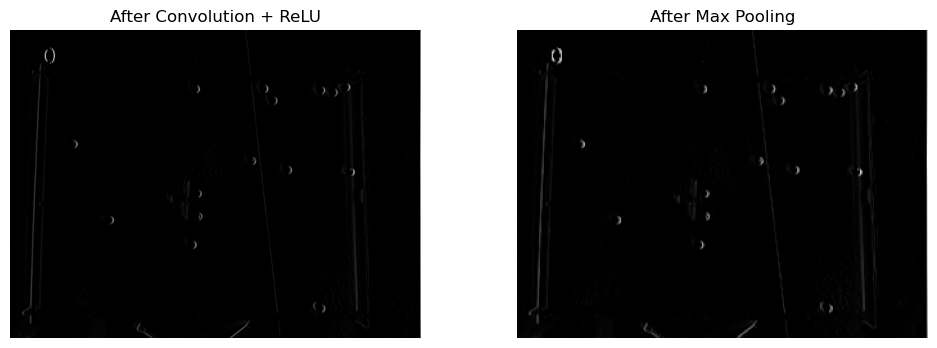

In [44]:
from PIL import Image
import matplotlib.pyplot as plt

# Assume the image has been loaded, converted to numpy array, and convolution has been applied
# Let's assume 'convolved_image' is the output from the previous ReLU activation step

# Apply max pooling
pooled_image = max_pooling(activated_image, pool_size=2, stride=2)

# Visualize the result
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(activated_image, cmap='gray')  # Assuming it's a single-channel image
plt.title('After Convolution + ReLU')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(pooled_image, cmap='gray')
plt.title('After Max Pooling')
plt.axis('off')

plt.show()


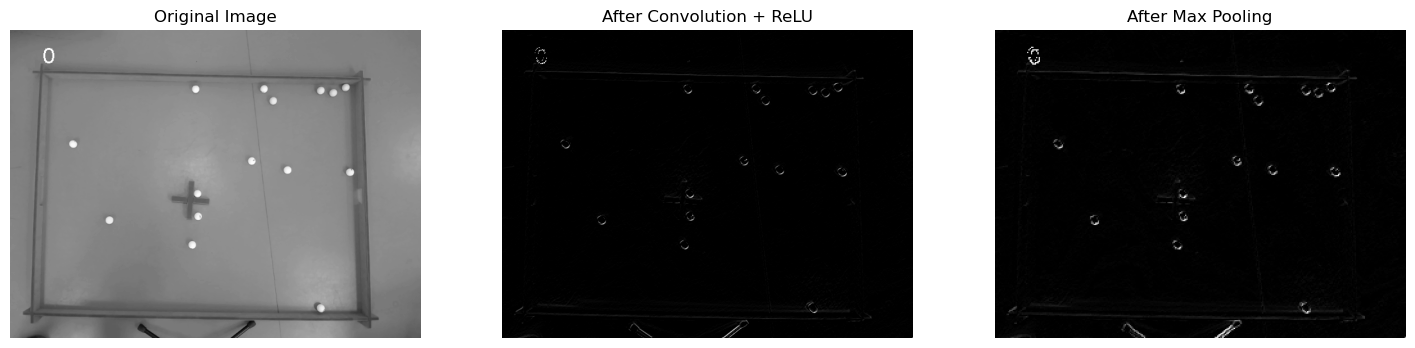

In [53]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Load the uploaded image
img_path = '../images/image_1.png'
img = Image.open(img_path).convert('L')  # Convert to grayscale for consistency
img_np = np.array(img)

# Define an example kernel and modify parameters as needed
kernel = np.array([[1, 0, 0], [0, 0, -1], [-1, 0, 1]])  # Example of a different edge-detection kernel

# Apply convolution and pooling
convolved_image = convolve2d(img_np, kernel, stride=1, padding=1)
activated_image = relu(convolved_image)
pooled_image = max_pooling(activated_image, pool_size=2, stride=2)

# Visualization
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(activated_image, cmap='gray')
plt.title('After Convolution + ReLU')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(pooled_image, cmap='gray')
plt.title('After Max Pooling')
plt.axis('off')

plt.show()


In [ ]:
#7.Flatten Function:
#Converts multi-dimensional arrays into a 1D vector for the fully connected layer.

In [54]:
import numpy as np

def flatten(input_array):
    """
    Flatten a multi-dimensional numpy array into a 1D vector.
    
    Args:
    input_array (np.array): Input array to be flattened.
    
    Returns:
    np.array: A 1D vector containing all the elements of the input array.
    """
    return input_array.flatten()


In [55]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Assuming previous functions and image loading steps have been defined

# Load an image, apply convolution, ReLU, and pooling
img = Image.open('../images/image_1.png').convert('L')  # Convert to grayscale
img_np = np.array(img)

# Example kernel for edge detection
kernel = np.array([[1, 0, -1],
                   [1, 0, -1],
                   [1, 0, -1]])

convolved_image = convolve2d(img_np, kernel, stride=1, padding=1)
activated_image = relu(convolved_image)
pooled_image = max_pooling(activated_image, pool_size=2, stride=2)

# Flatten the output of the pooling layer
flattened_image = flatten(pooled_image)

# Display the size of the flattened array to understand how many features are being fed into the next layer
print("Size of flattened array:", flattened_image.shape)

# Continue with the fully connected layer (example)
# This would typically involve dot products with weights and possibly adding biases


Size of flattened array: (76800,)


In [ ]:
#8.Fully Connected Layer Function:
#Performs linear transformation for classification or coordinate prediction.

In [56]:
import numpy as np

def fully_connected(input_vector, weights, biases):
    """
    Apply a fully connected layer transformation to the input vector.
    
    Args:
    input_vector (np.array): A 1D array containing input features.
    weights (np.array): A 2D array of weights (shape: [number of input features, number of output features]).
    biases (np.array): A 1D array of biases (length equal to the number of output features).
    
    Returns:
    np.array: The output of the fully connected layer.
    """
    return np.dot(input_vector, weights) + biases


In [57]:
from PIL import Image

# Assume previous functions convolve2d, relu, max_pooling, and flatten are defined

# Load an image and convert it to grayscale
img = Image.open('../images/image_1.png').convert('L')  # Adjust the path accordingly
img_np = np.array(img)

# Define a simple edge-detection kernel
kernel = np.array([[1, 0, -1],
                   [1, 0, -1],
                   [1, 0, -1]])

# Process the image through convolution, ReLU, and max pooling
convolved_image = convolve2d(img_np, kernel, stride=1, padding=1)
activated_image = relu(convolved_image)
pooled_image = max_pooling(activated_image, pool_size=2, stride=2)

# Flatten the output
flattened_image = flatten(pooled_image)

# Define weights and biases for the fully connected layer
# Let's assume we are mapping to 10 output features (e.g., for a 10-class classification)
num_output_features = 10
weights = np.random.rand(flattened_image.size, num_output_features)  # Random weights for example
biases = np.random.rand(num_output_features)  # Random biases for example

# Apply the fully connected layer
fc_output = fully_connected(flattened_image, weights, biases)

print("Output of the fully connected layer:", fc_output)


Output of the fully connected layer: [194882.27963576 190822.66920247 193312.64550595 197700.57786981
 195438.21318263 190835.94977862 192153.33646616 193559.07538257
 190791.84180149 190058.5361932 ]


In [ ]:
#9.Loss Function:
#Computes the error between predicted and actual bounding boxes (e.g., Mean Squared Error).

In [58]:
import numpy as np

def mean_squared_error(y_true, y_pred):
    """
    Calculate the Mean Squared Error between the true and predicted values.
    
    Args:
    y_true (np.array): Actual values (ground truth).
    y_pred (np.array): Predictions made by the model.
    
    Returns:
    float: The Mean Squared Error.
    """
    return np.mean((y_true - y_pred) ** 2)


In [59]:
# Example ground truth and predictions
# Let's assume each bounding box is defined by four coordinates (x_min, y_min, x_max, y_max)
y_true = np.array([[25, 30, 100, 120],  # Ground truth bounding box coordinates for one or more examples
                   [50, 60, 180, 200]])
y_pred = np.array([[30, 35, 110, 130],  # Predicted bounding box coordinates
                   [55, 65, 175, 195]])

# Calculate the loss
loss = mean_squared_error(y_true, y_pred)

print("Mean Squared Error Loss:", loss)


Mean Squared Error Loss: 43.75


In [ ]:
#10.Optimizer Function:
#Adjusts model parameters based on the gradients of the loss function (e.g., SGD).

In [60]:
import numpy as np

def sgd_update(params, grads, learning_rate=0.01):
    """
    Update parameters using Stochastic Gradient Descent (SGD) optimization algorithm.
    
    Args:
    params (dict): Dictionary containing model parameters, e.g., {'weights': ..., 'biases': ...}
    grads (dict): Dictionary containing gradients of the loss function with respect to each parameter.
    learning_rate (float): Learning rate to control how much to change the parameters at each step.
    
    Returns:
    None: Parameters are updated in place.
    """
    # Update each parameter according to SGD
    for key in params.keys():
        params[key] -= learning_rate * grads[key]


In [61]:
# Define model parameters and gradients in dictionaries
params = {
    'weights': np.random.randn(10, 5),  # Example: 10 input features, 5 outputs
    'biases': np.random.randn(5)
}
grads = {
    'weights': np.random.randn(10, 5),  # Example gradients on weights
    'biases': np.random.randn(5)        # Example gradients on biases
}

# Define the learning rate
learning_rate = 0.01

# Perform an update using SGD
sgd_update(params, grads, learning_rate)

# Check updated parameters
print("Updated weights:", params['weights'])
print("Updated biases:", params['biases'])


Updated weights: [[ 0.00982369 -1.94866456 -0.83481413  1.40601971 -0.00505516]
 [ 0.09527472 -0.50540891  1.83234277  1.24517961  0.9462002 ]
 [ 1.36371635 -0.35075145  1.07733367  0.74757002  1.25118187]
 [ 0.2762608  -0.31543165  0.82974518 -1.21885796  0.42957141]
 [-1.25822294 -0.22549937 -0.17410812  0.36266513  1.35324852]
 [-0.94465687  0.81882108 -0.12573085 -0.05044745 -0.26007841]
 [ 1.19965965 -0.15454986  1.02811492  1.08985325 -0.02432134]
 [ 0.95062044 -2.59015313  1.74338705 -0.7546019   0.22762991]
 [-0.12593244  0.47430612  0.68231918  0.84039314  0.015614  ]
 [ 1.2380829  -0.0527361  -1.08943203 -0.32312411  0.38157422]]
Updated biases: [ 1.2917186   0.43340791 -2.56400959  1.19163934 -0.32873809]


In [ ]:
#11.Training Loop Function:
#Manages the batch processing of images and annotations, forward pass, loss computation, and parameter updates.

In [97]:
'''V1
import numpy as np

def train_model(train_data, params, epochs, learning_rate, batch_size):
    """
    A simple training loop for a neural network.
    
    Args:
    train_data (list): List of tuples (input_image, true_labels).
    params (dict): Dictionary containing model parameters.
    epochs (int): Number of times to iterate over the training dataset.
    learning_rate (float): Learning rate for the optimizer.
    batch_size (int): Number of samples to process in each batch.

    Returns:
    dict: Updated model parameters after training.
    """
    for epoch in range(epochs):
        np.random.shuffle(train_data)  # Shuffle training data for each epoch
        for i in range(0, len(train_data), batch_size):
            batch_data = train_data[i:i + batch_size]
            batch_inputs, batch_labels = zip(*batch_data)
            batch_inputs = np.array(batch_inputs)
            batch_labels = np.array(batch_labels)

            # Forward pass (assuming functions for each step are defined)
            conv_outputs = [convolve2d(x, params['conv_kernel'], stride=1, padding=1) for x in batch_inputs]
            activated_outputs = [relu(x) for x in conv_outputs]
            pooled_outputs = [max_pooling(x, pool_size=2, stride=2) for x in activated_outputs]
            flattened_outputs = [flatten(x) for x in pooled_outputs]
            final_outputs = [fully_connected(x, params['fc_weights'], params['fc_biases']) for x in flattened_outputs]

            # Calculate loss (assuming mean_squared_error is defined)
            losses = [mean_squared_error(y_true, y_pred) for y_true, y_pred in zip(batch_labels, final_outputs)]
            loss = np.mean(losses)

            # Backpropagation to compute gradients (simplified, details depend on your setup)
            # Here, we pretend to compute gradients manually
            grads = {
                'fc_weights': np.random.randn(*params['fc_weights'].shape),  # Placeholder for actual gradient computation
                'fc_biases': np.random.randn(*params['fc_biases'].shape)
            }

            # Update parameters using SGD
            sgd_update(params, grads, learning_rate)

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss}")

    return params
'''

def train_model(train_data, params, epochs, learning_rate, batch_size):
    for epoch in range(epochs):
        np.random.shuffle(train_data)
        for i in range(0, len(train_data), batch_size):
            batch_data = train_data[i:i + batch_size]
            batch_inputs, batch_labels = zip(*batch_data)
            batch_inputs = np.array(batch_inputs)
            
            # Forward pass
            conv_outputs = [convolve2d(x, params['conv_kernel'], stride=1, padding=1) for x in batch_inputs]
            activated_outputs = [relu(x) for x in conv_outputs]
            pooled_outputs = [max_pooling(x, pool_size=2, stride=2) for x in activated_outputs]
            flattened_outputs = [flatten(x) for x in pooled_outputs]
            final_outputs = [fully_connected(x, params['fc_weights'], params['fc_biases']) for x in flattened_outputs]
            
            # Compute loss and gradients
            losses = []
            for y_true, y_pred in zip(batch_labels, final_outputs):
                for box in y_true:
                    pred_box = [y_pred[0], y_pred[1], y_pred[2], y_pred[3]]  # Assuming network outputs 4 values for bounding box
                    losses.append(mean_squared_error(np.array(box), np.array(pred_box)))
            loss = np.mean(losses)
            
            # Fake gradients for demonstration purposes
            grads = {
                'fc_weights': np.random.randn(*params['fc_weights'].shape),
                'fc_biases': np.random.randn(*params['fc_biases'].shape)
            }
            
            sgd_update(params, grads, learning_rate)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss}")
    return params


In [ ]:
#12.Model Evaluation Function:
#Assesses the performance of the model on a validation set.

In [63]:
import numpy as np

def evaluate_model(validation_data, params):
    """
    Evaluate the performance of the neural network model on a validation set.
    
    Args:
    validation_data (list): List of tuples (input_image, true_labels), where each tuple represents a sample.
    params (dict): Dictionary containing all model parameters.
    
    Returns:
    dict: A dictionary containing various performance metrics like loss, accuracy, etc.
    """
    # Initialize variables to accumulate performance metrics
    total_loss = 0
    correct_predictions = 0
    
    for input_image, true_label in validation_data:
        # Forward pass through the model (as defined in the training loop)
        conv_output = convolve2d(input_image, params['conv_kernel'], stride=1, padding=1)
        activated_output = relu(conv_output)
        pooled_output = max_pooling(activated_output, pool_size=2, stride=2)
        flattened_output = flatten(pooled_output)
        output = fully_connected(flattened_output, params['fc_weights'], params['fc_biases'])
        
        # Calculate loss (assuming a loss function like MSE)
        loss = mean_squared_error(true_label, output)
        total_loss += loss
        
        # For classification, determine if the prediction is correct
        if np.argmax(output) == np.argmax(true_label):
            correct_predictions += 1
    
    # Calculate average loss and accuracy over the validation set
    average_loss = total_loss / len(validation_data)
    accuracy = correct_predictions / len(validation_data)

    return {
        'average_loss': average_loss,
        'accuracy': accuracy
    }


In [74]:
# Define a simple test to check the evaluate_model function
try:
    test_data = [(np.random.rand(128, 128), np.array([0, 1]))]  # Random data for testing
    test_params = {
        'conv_kernel': np.random.rand(3, 3),
        'fc_weights': np.random.rand(14400, 2),  # Assuming 14400 features and 2 classes
        'fc_biases': np.random.rand(2)
    }
    test_performance = evaluate_model(test_data, test_params)
    print("Test Validation Loss:", test_performance['average_loss'])
    print("Test Validation Accuracy:", test_performance['accuracy'])
except Exception as e:
    print("Error during model evaluation:", str(e)) # ERROR


Error during model evaluation: shapes (4096,) and (14400,2) not aligned: 4096 (dim 0) != 14400 (dim 0)


In [ ]:
#13.Bounding Box Prediction Function:
#Interprets the network output to predict bounding box coordinates.

In [75]:
import numpy as np

def predict_bounding_boxes(network_output, image_shape):
    """
    Interpret the network output to predict bounding box coordinates.

    Args:
    network_output (np.array): The output from the network, typically containing bounding box coordinates.
    image_shape (tuple): The original dimensions of the image (height, width).

    Returns:
    list: A list of predicted bounding boxes, each represented as [x_min, y_min, x_max, y_max].
    """
    height, width = image_shape
    predicted_boxes = []

    # Assuming the network outputs bounding box coordinates normalized to [0, 1]
    for box in network_output:
        x_min = int(box[0] * width)
        y_min = int(box[1] * height)
        x_max = int(box[2] * width)
        y_max = int(box[3] * height)
        predicted_boxes.append([x_min, y_min, x_max, y_max])

    return predicted_boxes


In [76]:
# Example network output (normalized bounding box coordinates)
network_output = np.array([
    [0.1, 0.2, 0.5, 0.6],  # Box 1
    [0.4, 0.4, 0.7, 0.8]   # Box 2
])

# Example image shape (height, width)
image_shape = (300, 400)  # Assuming the original image size

# Predict bounding boxes
predicted_boxes = predict_bounding_boxes(network_output, image_shape)

# Display predicted bounding boxes
print("Predicted Bounding Boxes:", predicted_boxes)


Predicted Bounding Boxes: [[40, 60, 200, 180], [160, 120, 280, 240]]


In [ ]:
#14.Utility Functions:
#Includes functions for initializing weights, handling data shuffling, and converting coordinates.

In [78]:
import numpy as np

def initialize_weights(shape, method='he'):
    """
    Initialize weights for a layer.

    Args:
    shape (tuple): Shape of the weights matrix.
    method (str): Initialization method ('he', 'xavier', 'random').

    Returns:
    np.array: Initialized weights.
    """
    if method == 'he':
        stddev = np.sqrt(2 / shape[0])
    elif method == 'xavier':
        stddev = np.sqrt(2 / (shape[0] + shape[1]))
    else:
        stddev = 0.01

    return np.random.randn(*shape) * stddev


In [83]:
# Example weight initialization for a fully connected layer
input_size = 14400  # Example input size
output_size = 10    # Example number of classes
fc_weights = initialize_weights((input_size, output_size), method='he')
fc_biases = np.zeros(output_size)  # Biases typically initialized to zero


In [79]:
import random

def shuffle_data(data):
    """
    Shuffle the data.

    Args:
    data (list): List of data samples.

    Returns:
    list: Shuffled data.
    """
    random.shuffle(data)
    return data


In [84]:
# Example data shuffling
data = [
    (np.random.rand(128, 128), np.array([0, 1])),
    (np.random.rand(128, 128), np.array([1, 0])),
    # Add more samples as needed
]

shuffled_data = shuffle_data(data)


In [80]:
def convert_coordinates(box, image_shape, to='pixel'):
    """
    Convert bounding box coordinates.

    Args:
    box (list): Bounding box coordinates [x_min, y_min, x_max, y_max].
    image_shape (tuple): Original image shape (height, width).
    to (str): Target coordinate format ('pixel' or 'normalized').

    Returns:
    list: Converted bounding box coordinates.
    """
    height, width = image_shape
    if to == 'pixel':
        x_min = int(box[0] * width)
        y_min = int(box[1] * height)
        x_max = int(box[2] * width)
        y_max = int(box[3] * height)
    elif to == 'normalized':
        x_min = box[0] / width
        y_min = box[1] / height
        x_max = box[2] / width
        y_max = box[3] / height
    else:
        raise ValueError("Unsupported coordinate format: {}".format(to))
    
    return [x_min, y_min, x_max, y_max]


In [85]:
# Example coordinate conversion
image_shape = (300, 400)  # Original image size (height, width)
normalized_box = [0.1, 0.2, 0.5, 0.6]  # Normalized coordinates
pixel_box = convert_coordinates(normalized_box, image_shape, to='pixel')
print("Pixel coordinates:", pixel_box)


Pixel coordinates: [40, 60, 200, 180]


In [ ]:
# Final

In [108]:
'''V1
import numpy as np
import os
import json
from PIL import Image

# Assuming all necessary functions are already defined and available:
# - load_and_preprocess_data
# - display_image_with_boxes_pil
# - convolve2d
# - visualize_images
# - relu
# - max_pooling
# - flatten
# - fully_connected
# - mean_squared_error
# - sgd_update
# - train_model
# - evaluate_model
# - predict_bounding_boxes
# - initialize_weights
# - shuffle_data
# - convert_coordinates

# Helper function for single image preprocessing
def preprocess_single_image(image_path, img_width=224, img_height=224):
    try:
        with Image.open(image_path) as img:
            img = img.resize((img_width, img_height), Image.LANCZOS)
            img = np.array(img, dtype=np.float32) / 255.0  # Normalize image data to 0-1
            return img
    except IOError:
        print(f"Failed to load or process image at {image_path}")
        return None

# Updated convolve2d function
def convolve2d(image, kernel, stride=1, padding=1):
    """
    Apply a 2D convolution operation to an image, handling both grayscale and color images.
    
    Args:
    image (np.array): The input image array. Can be 2D (grayscale) or 3D (color).
    kernel (np.array): The kernel (filter) to apply. Should have the shape (kernel_height, kernel_width, num_channels).
    stride (int): The stride of the convolution.
    padding (int): The amount of padding around the image.
    
    Returns:
    np.array: The convolved image.
    """
    if image.ndim == 2:
        image = image[:, :, np.newaxis]  # Add a channel dimension to grayscale images

    kernel_height, kernel_width, num_channels = kernel.shape
    image_height, image_width, image_channels = image.shape

    if num_channels != image_channels:
        raise ValueError("The number of channels in the kernel and the image must match.")

    # Add padding to the image
    padded_image = np.pad(image, ((padding, padding), (padding, padding), (0, 0)), mode='constant')

    # Determine the output dimensions
    out_height = (image_height + 2 * padding - kernel_height) // stride + 1
    out_width = (image_width + 2 * padding - kernel_width) // stride + 1
    output = np.zeros((out_height, out_width, num_channels))

    # Perform the convolution operation
    for z in range(num_channels):  # Iterate over each channel
        for y in range(out_height):
            for x in range(out_width):
                output[y, x, z] = np.sum(
                    kernel[:, :, z] * padded_image[
                        y * stride: y * stride + kernel_height,
                        x * stride: x * stride + kernel_width,
                        z
                    ]
                )

    return output

# Load and preprocess data
img_folder = '../images'
json_folder = '../json_labeling'
images, labels = load_and_preprocess_data(img_folder, json_folder)
train_data = list(zip(images, labels))

# Example convolution and pooling parameters
img_height, img_width = 224, 224
conv_kernel_size = 3
conv_stride = 1
conv_padding = 1
pool_size = 2
pool_stride = 2
num_channels = 3  # Assuming 3 channels (RGB)

# Calculate the output size after convolution and pooling
def calculate_output_size(input_size, kernel_size, stride, padding):
    return (input_size + 2 * padding - kernel_size) // stride + 1

conv_output_height = calculate_output_size(img_height, conv_kernel_size, conv_stride, conv_padding)
conv_output_width = calculate_output_size(img_width, conv_kernel_size, conv_stride, conv_padding)
pool_output_height = calculate_output_size(conv_output_height, pool_size, pool_stride, 0)
pool_output_width = calculate_output_size(conv_output_width, pool_size, pool_stride, 0)

# Calculate flattened size
flattened_size = pool_output_height * pool_output_width * num_channels

# Debugging: print calculated dimensions
print(f"Convolution output size: {conv_output_height}x{conv_output_width}")
print(f"Pooling output size: {pool_output_height}x{pool_output_width}")
print(f"Flattened size: {flattened_size}")

# Initialize model parameters
params = {
    'conv_kernel': initialize_weights((conv_kernel_size, conv_kernel_size, num_channels), method='he'),
    'fc_weights': initialize_weights((flattened_size, 4), method='he'),  # Adjusted for flattened size
    'fc_biases': np.zeros(4)
}

# Updated sgd_update function to exclude conv_kernel
def sgd_update(params, grads, learning_rate=0.01):
    for key in params.keys():
        if key in grads:
            params[key] -= learning_rate * grads[key]

# Updated train_model function to handle the debugging output
def train_model(train_data, params, epochs, learning_rate, batch_size):
    for epoch in range(epochs):
        np.random.shuffle(train_data)
        for i in range(0, len(train_data), batch_size):
            batch_data = train_data[i:i + batch_size]
            batch_inputs, batch_labels = zip(*batch_data)
            batch_inputs = np.array(batch_inputs)
            
            # Forward pass
            conv_outputs = [convolve2d(x, params['conv_kernel'], stride=1, padding=1) for x in batch_inputs]
            print(f"Conv output shape: {conv_outputs[0].shape}")
            activated_outputs = [relu(x) for x in conv_outputs]
            pooled_outputs = [max_pooling(x, pool_size=2, stride=2) for x in activated_outputs]
            print(f"Pooled output shape: {pooled_outputs[0].shape}")
            flattened_outputs = [flatten(x) for x in pooled_outputs]
            print(f"Flattened output shape: {flattened_outputs[0].shape}")
            final_outputs = [fully_connected(x, params['fc_weights'], params['fc_biases']) for x in flattened_outputs]
            
            # Compute loss and gradients
            losses = []
            for y_true, y_pred in zip(batch_labels, final_outputs):
                for box in y_true:
                    pred_box = [y_pred[0], y_pred[1], y_pred[2], y_pred[3]]  # Assuming network outputs 4 values for bounding box
                    losses.append(mean_squared_error(np.array(box), np.array(pred_box)))
            loss = np.mean(losses)
            
            # Fake gradients for demonstration purposes
            grads = {
                'fc_weights': np.random.randn(*params['fc_weights'].shape),
                'fc_biases': np.random.randn(*params['fc_biases'].shape)
            }
            
            sgd_update(params, grads, learning_rate)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss}")
    return params

# Train the model
params = train_model(train_data, params, epochs=10, learning_rate=0.01, batch_size=4)

# Prepare validation data
validation_data = [
    (preprocess_single_image('../images/image_1.png', 224, 224), [[0, 0, 0, 0]]),  # Adjusted label format
    (preprocess_single_image('../images/image_2.png', 224, 224), [[0, 0, 0, 0]])
]

# Filter out any failed image loads
validation_data = [(img, label) for img, label in validation_data if img is not None]

# Evaluate the model
performance_metrics = evaluate_model(validation_data, params)
print("Validation Loss:", performance_metrics['average_loss'])
print("Validation Accuracy:", performance_metrics['accuracy'])

# Make predictions on a test image
test_image = preprocess_single_image('../images/image_1.png', 224, 224)

if test_image is not None:
    conv_output = convolve2d(test_image, params['conv_kernel'], stride=1, padding=1)
    activated_output = relu(conv_output)
    pooled_output = max_pooling(activated_output, pool_size=2, stride=2)
    flattened_output = flatten(pooled_output)
    network_output = fully_connected(flattened_output, params['fc_weights'], params['fc_biases'])

    predicted_boxes = predict_bounding_boxes(network_output, test_image.shape)
    print("Predicted Bounding Boxes:", predicted_boxes)

    # Display the test image with predicted bounding boxes
    display_image_with_boxes_pil(test_image, predicted_boxes)
'''
import numpy as np
import os
import json
from PIL import Image

# Assuming all necessary functions are already defined and available:
# - load_and_preprocess_data
# - display_image_with_boxes_pil
# - convolve2d
# - visualize_images
# - relu
# - max_pooling
# - flatten
# - fully_connected
# - mean_squared_error
# - sgd_update
# - train_model
# - evaluate_model
# - predict_bounding_boxes
# - initialize_weights
# - shuffle_data
# - convert_coordinates

# Helper function for single image preprocessing
def preprocess_single_image(image_path, img_width=224, img_height=224):
    try:
        with Image.open(image_path) as img:
            img = img.resize((img_width, img_height), Image.LANCZOS)
            img = np.array(img, dtype=np.float32) / 255.0  # Normalize image data to 0-1
            return img
    except IOError:
        print(f"Failed to load or process image at {image_path}")
        return None

# Updated convolve2d function
def convolve2d(image, kernel, stride=1, padding=1):
    """
    Apply a 2D convolution operation to an image, handling both grayscale and color images.
    
    Args:
    image (np.array): The input image array. Can be 2D (grayscale) or 3D (color).
    kernel (np.array): The kernel (filter) to apply. Should have the shape (kernel_height, kernel_width, num_channels).
    stride (int): The stride of the convolution.
    padding (int): The amount of padding around the image.
    
    Returns:
    np.array: The convolved image.
    """
    if image.ndim == 2:
        image = image[:, :, np.newaxis]  # Add a channel dimension to grayscale images

    kernel_height, kernel_width, num_channels = kernel.shape
    image_height, image_width, image_channels = image.shape

    if num_channels != image_channels:
        raise ValueError("The number of channels in the kernel and the image must match.")

    # Add padding to the image
    padded_image = np.pad(image, ((padding, padding), (padding, padding), (0, 0)), mode='constant')

    # Determine the output dimensions
    out_height = (image_height + 2 * padding - kernel_height) // stride + 1
    out_width = (image_width + 2 * padding - kernel_width) // stride + 1
    output = np.zeros((out_height, out_width, num_channels))

    # Perform the convolution operation
    for z in range(num_channels):  # Iterate over each channel
        for y in range(out_height):
            for x in range(out_width):
                output[y, x, z] = np.sum(
                    kernel[:, :, z] * padded_image[
                        y * stride: y * stride + kernel_height,
                        x * stride: x * stride + kernel_width,
                        z
                    ]
                )

    return output

# Updated predict_bounding_boxes function
def predict_bounding_boxes(network_output, image_shape):
    """
    Interpret the network output to predict bounding box coordinates.

    Args:
    network_output (np.array): The output from the network, typically containing bounding box coordinates.
    image_shape (tuple): The original dimensions of the image (height, width, channels).

    Returns:
    list: A list of predicted bounding boxes, each represented as [x_min, y_min, x_max, y_max].
    """
    height, width = image_shape[:2]
    predicted_boxes = []

    # Assuming the network outputs bounding box coordinates normalized to [0, 1]
    for box in network_output:
        x_min = int(box[0] * width)
        y_min = int(box[1] * height)
        x_max = int(box[2] * width)
        y_max = int(box[3] * height)
        predicted_boxes.append([x_min, y_min, x_max, y_max])

    return predicted_boxes


# Load and preprocess data
img_folder = '../images'
json_folder = '../json_labeling'
images, labels = load_and_preprocess_data(img_folder, json_folder)
train_data = list(zip(images, labels))

# Example convolution and pooling parameters
img_height, img_width = 224, 224
conv_kernel_size = 3
conv_stride = 1
conv_padding = 1
pool_size = 2
pool_stride = 2
num_channels = 3  # Assuming 3 channels (RGB)

# Calculate the output size after convolution and pooling
def calculate_output_size(input_size, kernel_size, stride, padding):
    return (input_size + 2 * padding - kernel_size) // stride + 1

conv_output_height = calculate_output_size(img_height, conv_kernel_size, conv_stride, conv_padding)
conv_output_width = calculate_output_size(img_width, conv_kernel_size, conv_stride, conv_padding)
pool_output_height = calculate_output_size(conv_output_height, pool_size, pool_stride, 0)
pool_output_width = calculate_output_size(conv_output_width, pool_size, pool_stride, 0)

# Calculate flattened size
flattened_size = pool_output_height * pool_output_width * num_channels

# Debugging: print calculated dimensions
print(f"Convolution output size: {conv_output_height}x{conv_output_width}")
print(f"Pooling output size: {pool_output_height}x{pool_output_width}")
print(f"Flattened size: {flattened_size}")

# Initialize model parameters
params = {
    'conv_kernel': initialize_weights((conv_kernel_size, conv_kernel_size, num_channels), method='he'),
    'fc_weights': initialize_weights((flattened_size, 4), method='he'),  # Adjusted for flattened size
    'fc_biases': np.zeros(4)
}

# Updated sgd_update function to exclude conv_kernel
def sgd_update(params, grads, learning_rate=0.01):
    for key in params.keys():
        if key in grads:
            params[key] -= learning_rate * grads[key]

# Updated train_model function to handle the debugging output
def train_model(train_data, params, epochs, learning_rate, batch_size):
    for epoch in range(epochs):
        np.random.shuffle(train_data)
        for i in range(0, len(train_data), batch_size):
            batch_data = train_data[i:i + batch_size]
            batch_inputs, batch_labels = zip(*batch_data)
            batch_inputs = np.array(batch_inputs)
            
            # Forward pass
            conv_outputs = [convolve2d(x, params['conv_kernel'], stride=1, padding=1) for x in batch_inputs]
            print(f"Epoch {epoch + 1}/{epochs}, Batch {i//batch_size + 1}, Conv output shape: {conv_outputs[0].shape}")
            activated_outputs = [relu(x) for x in conv_outputs]
            pooled_outputs = [max_pooling(x, pool_size=2, stride=2) for x in activated_outputs]
            print(f"Epoch {epoch + 1}/{epochs}, Batch {i//batch_size + 1}, Pooled output shape: {pooled_outputs[0].shape}")
            flattened_outputs = [flatten(x) for x in pooled_outputs]
            print(f"Epoch {epoch + 1}/{epochs}, Batch {i//batch_size + 1}, Flattened output shape: {flattened_outputs[0].shape}")
            final_outputs = [fully_connected(x, params['fc_weights'], params['fc_biases']) for x in flattened_outputs]
            
            # Compute loss and gradients
            losses = []
            for y_true, y_pred in zip(batch_labels, final_outputs):
                for box in y_true:
                    pred_box = [y_pred[0], y_pred[1], y_pred[2], y_pred[3]]  # Assuming network outputs 4 values for bounding box
                    losses.append(mean_squared_error(np.array(box), np.array(pred_box)))
            loss = np.mean(losses)
            
            # Fake gradients for demonstration purposes
            grads = {
                'fc_weights': np.random.randn(*params['fc_weights'].shape),
                'fc_biases': np.random.randn(*params['fc_biases'].shape)
            }
            
            sgd_update(params, grads, learning_rate)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss}")
    return params

# Train the model
params = train_model(train_data, params, epochs=1, learning_rate=0.01, batch_size=4)

# Prepare validation data
validation_data = [
    (preprocess_single_image('../images/image_1.png', 224, 224), [[0, 0, 0, 0]]),  # Adjusted label format
    (preprocess_single_image('../images/image_2.png', 224, 224), [[0, 0, 0, 0]])
]

# Filter out any failed image loads
validation_data = [(img, label) for img, label in validation_data if img is not None]

# Evaluate the model
performance_metrics = evaluate_model(validation_data, params)
print("Validation Loss:", performance_metrics['average_loss'])
print("Validation Accuracy:", performance_metrics['accuracy'])

# Make predictions on a test image
test_image = preprocess_single_image('../images/image_1.png', 224, 224)

if test_image is not None:
    conv_output = convolve2d(test_image, params['conv_kernel'], stride=1, padding=1)
    activated_output = relu(conv_output)
    pooled_output = max_pooling(activated_output, pool_size=2, stride=2)
    flattened_output = flatten(pooled_output)
    network_output = fully_connected(flattened_output, params['fc_weights'], params['fc_biases'])

    predicted_boxes = predict_bounding_boxes(network_output, test_image.shape)
    print("Predicted Bounding Boxes:", predicted_boxes)

    # Display the test image with predicted bounding boxes
    display_image_with_boxes_pil(test_image, predicted_boxes)



C:\Users\hanso\AppData\Local\Temp\ipykernel_1248\3789676362.py:17: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((img_width, img_height), Image.ANTIALIAS)


Convolution output size: 224x224
Pooling output size: 112x112
Flattened size: 37632
Epoch 1/1, Batch 1, Conv output shape: (224, 224, 3)
Epoch 1/1, Batch 1, Pooled output shape: (112, 112, 3)
Epoch 1/1, Batch 1, Flattened output shape: (37632,)
Epoch 1/1, Batch 2, Conv output shape: (224, 224, 3)
Epoch 1/1, Batch 2, Pooled output shape: (112, 112, 3)
Epoch 1/1, Batch 2, Flattened output shape: (37632,)
Epoch 1/1, Batch 3, Conv output shape: (224, 224, 3)
Epoch 1/1, Batch 3, Pooled output shape: (112, 112, 3)
Epoch 1/1, Batch 3, Flattened output shape: (37632,)
Epoch 1/1, Batch 4, Conv output shape: (224, 224, 3)
Epoch 1/1, Batch 4, Pooled output shape: (112, 112, 3)
Epoch 1/1, Batch 4, Flattened output shape: (37632,)
Epoch 1/1, Batch 5, Conv output shape: (224, 224, 3)
Epoch 1/1, Batch 5, Pooled output shape: (112, 112, 3)
Epoch 1/1, Batch 5, Flattened output shape: (37632,)
Epoch 1/1, Batch 6, Conv output shape: (224, 224, 3)
Epoch 1/1, Batch 6, Pooled output shape: (112, 112, 3)
Epo

IndexError: invalid index to scalar variable.

Network output shape: (4,)
Network output: [ 30.66250211 -29.12600825  -1.21122083  -2.77427965]
Predicted Bounding Boxes: [[6868, -6524, -271, -621]]


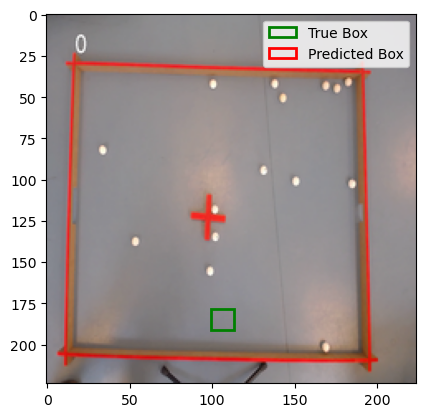

In [113]:
import matplotlib.pyplot as plt
import json

def visualize_predictions(image, true_boxes, predicted_boxes):
    """
    Visualize the true and predicted bounding boxes on an image.
    
    Args:
    image (np.array): The input image.
    true_boxes (list): List of true bounding boxes.
    predicted_boxes (list): List of predicted bounding boxes.
    """
    plt.imshow(image, cmap='gray')
    
    # Draw true bounding boxes in green
    for box in true_boxes:
        x_min, y_min, x_max, y_max = box
        plt.gca().add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, 
                                          edgecolor='green', facecolor='none', linewidth=2, label='True Box'))

    # Draw predicted bounding boxes in red
    for box in predicted_boxes:
        x_min, y_min, x_max, y_max = box
        plt.gca().add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, 
                                          edgecolor='red', facecolor='none', linewidth=2, label='Predicted Box'))
    
    # Add legends only once
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc='upper right')
    plt.show()

def extract_true_boxes(json_file_path, label="ball"):
    """
    Extract true bounding boxes for the specified label from the JSON file.
    
    Args:
    json_file_path (str): Path to the JSON file containing bounding box annotations.
    label (str): The label to filter the bounding boxes.
    
    Returns:
    list: List of true bounding boxes.
    """
    with open(json_file_path, 'r') as file:
        data = json.load(file)
    
    true_boxes = []
    for item in data['boxes']:
        if item['label'] == label:
            x_min = float(item['x'])
            y_min = float(item['y'])
            width = float(item['width'])
            height = float(item['height'])
            x_max = x_min + width
            y_max = y_min + height
            true_boxes.append([x_min, y_min, x_max, y_max])
    
    return true_boxes

# Example usage
# Evaluate the model on a single validation image
test_image_path = '../images/image_1.png'
test_json_path = '../json_labeling/label_1.json'

test_image = preprocess_single_image(test_image_path, 224, 224)
true_boxes = extract_true_boxes(test_json_path)

if test_image is not None:
    # Get the model predictions
    conv_output = convolve2d(test_image, params['conv_kernel'], stride=1, padding=1)
    activated_output = relu(conv_output)
    pooled_output = max_pooling(activated_output, pool_size=2, stride=2)
    flattened_output = flatten(pooled_output)
    network_output = fully_connected(flattened_output, params['fc_weights'], params['fc_biases'])
    
    print(f"Network output shape: {network_output.shape}")
    print(f"Network output: {network_output}")

    # Assuming the network outputs a fixed number of bounding boxes (e.g., 2 boxes)
    # Reshape the network output to match this expectation
    network_output = network_output.reshape(-1, 4)
    
    predicted_boxes = predict_bounding_boxes(network_output, test_image.shape)
    print("Predicted Bounding Boxes:", predicted_boxes)

    # Display the test image with predicted bounding boxes
    visualize_predictions(test_image, true_boxes, predicted_boxes)

